In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
sys.path.insert(0, "../timeseries/")

In [3]:
import warnings

from forecast import analyse_final_model
from forecast import evaluate_models
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
warnings.filterwarnings("ignore")
import pandas as pd
from matplotlib import pyplot as plt
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from forecast import split_timeseries, analyse_final_model
import numpy as np

In [4]:
coin_returns = pd.read_csv("coins.csv", index_col="date")

In [5]:
series = coin_returns["frax"].dropna()

In [6]:
series[-6:-1]

date
2022-07-02    1.001391
2022-07-03    0.999813
2022-07-04    0.995538
2022-07-05    0.998632
2022-07-06    0.998313
Name: frax, dtype: float64

In [7]:
autocorr = {}
for lag in range(1, 10):
    autocorr[lag] = series.autocorr(lag)
    print("Autocorrelation"+ "("+ str(lag)+"): " + str(round(autocorr[lag],2)))
print("Max. Autocorrelation Lag: "+str(max(autocorr, key=autocorr.get)))

Autocorrelation(1): 0.21
Autocorrelation(2): 0.18
Autocorrelation(3): 0.19
Autocorrelation(4): 0.2
Autocorrelation(5): 0.09
Autocorrelation(6): 0.07
Autocorrelation(7): 0.09
Autocorrelation(8): -0.01
Autocorrelation(9): 0.05
Max. Autocorrelation Lag: 1


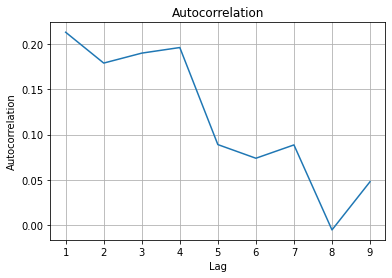

In [8]:
plt.plot(list(autocorr.keys()),list(autocorr.values()))
plt.title("Autocorrelation")
plt.ylabel("Autocorrelation")
plt.xlabel("Lag")
plt.grid()
plt.show()

### ARIMA model

In [9]:
# Set ARIMA parameters to be looped through
arima_parameters = []
p_values = range(0,4)
d_values = [0,1]
q_values = range(0,4)
for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                arima_parameters.append(order)

In [10]:
# Count of possible ARIMA models
len(arima_parameters)

32

In [11]:
# Split data in train and test data
in_sample, out_sample = split_timeseries(series)
train, test = in_sample.values, out_sample.values
values = [x for x in series.values]
print("Count train sample: " + str(len(train)))
print("Count test sample: " + str(len(test)))

Count train sample: 451
Count test sample: 113


In [12]:
# Information criteria per model
aic_dict = {}
bic_dict = {}
for parameters in arima_parameters:
    model = ARIMA(train, order=parameters)
    aic_dict[parameters] = model.fit().aic
    bic_dict[parameters] = model.fit().bic
for aic in aic_dict:
    print("AIC:" + str(aic) +": "+ str(int(aic_dict[aic])))
    print("BIC:" + str(aic) +": "+ str(int(bic_dict[aic])))
print("__________________________")
min_aic = aic_dict[min(aic_dict, key=aic_dict.get)]
min_bic = bic_dict[min(bic_dict, key=bic_dict.get)]
print("Best AIC: " + str(min(aic_dict, key=aic_dict.get)) +": "+ str(int(min_aic)))
print("Best BIC: " + str(min(bic_dict, key=bic_dict.get)) +": "+ str(int(min_bic)))

AIC:(0, 0, 0): -3279
BIC:(0, 0, 0): -3271
AIC:(0, 0, 1): -3290
BIC:(0, 0, 1): -3278
AIC:(0, 0, 2): -3294
BIC:(0, 0, 2): -3277
AIC:(0, 0, 3): -3298
BIC:(0, 0, 3): -3277
AIC:(0, 1, 0): -3067
BIC:(0, 1, 0): -3063
AIC:(0, 1, 1): -3278
BIC:(0, 1, 1): -3270
AIC:(0, 1, 2): -3282
BIC:(0, 1, 2): -3270
AIC:(0, 1, 3): -3278
BIC:(0, 1, 3): -3262
AIC:(1, 0, 0): -3294
BIC:(1, 0, 0): -3282
AIC:(1, 0, 1): -3307
BIC:(1, 0, 1): -3290
AIC:(1, 0, 2): -3306
BIC:(1, 0, 2): -3285
AIC:(1, 0, 3): -3308
BIC:(1, 0, 3): -3283
AIC:(1, 1, 0): -3184
BIC:(1, 1, 0): -3176
AIC:(1, 1, 1): -3279
BIC:(1, 1, 1): -3266
AIC:(1, 1, 2): -3280
BIC:(1, 1, 2): -3263
AIC:(1, 1, 3): -3276
BIC:(1, 1, 3): -3256
AIC:(2, 0, 0): -3299
BIC:(2, 0, 0): -3282
AIC:(2, 0, 1): -3303
BIC:(2, 0, 1): -3282
AIC:(2, 0, 2): -3303
BIC:(2, 0, 2): -3278
AIC:(2, 0, 3): -3307
BIC:(2, 0, 3): -3278
AIC:(2, 1, 0): -3235
BIC:(2, 1, 0): -3222
AIC:(2, 1, 1): -3276
BIC:(2, 1, 1): -3260
AIC:(2, 1, 2): -3276
BIC:(2, 1, 2): -3256
AIC:(2, 1, 3): -3278
BIC:(2, 1, 3)

In [13]:
# Select model
best_model = (1,0,1)
print("Best model: "+ str(best_model))

Best model: (1, 0, 1)


TypeError: plot got an unexpected keyword argument 'x'

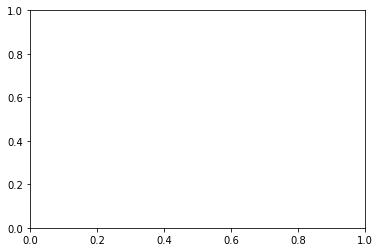

In [23]:
analyse_final_model(series, best_model)

In [15]:
model = ARIMA(train, order=best_model)
forecast = model.fit().predict(start = len(train), 
                          end = (len(train))+len(test)-1, 
                          typ = 'levels')

In [17]:
len(forecast)

113

In [18]:
out_sample["forecast"] = forecast

<AxesSubplot:xlabel='date'>

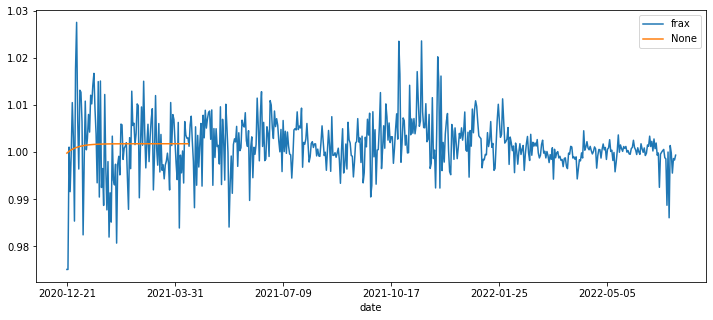

In [19]:
series.plot(figsize = (12, 5), legend = True)
pd.Series(forecast).plot(legend=True)

In [20]:
out_sample.rename(columns={"frax":"actual"}).plot(grid=True)

TypeError: Series.rename() got an unexpected keyword argument 'columns'

In [ ]:
analyse_final_model(series, arima_order)